In [4]:
import wandb
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from ift6758.data import get_wandb_data
import ift6758.visualizations.baseline_models_figures as baseline_models_figures

wandb:   1 of 1 files downloaded.  
wandb:   4 of 4 files downloaded.  


Artifact downloaded to: ../ift6758/data/wandb_artifacts//train_val_feature_eng_1


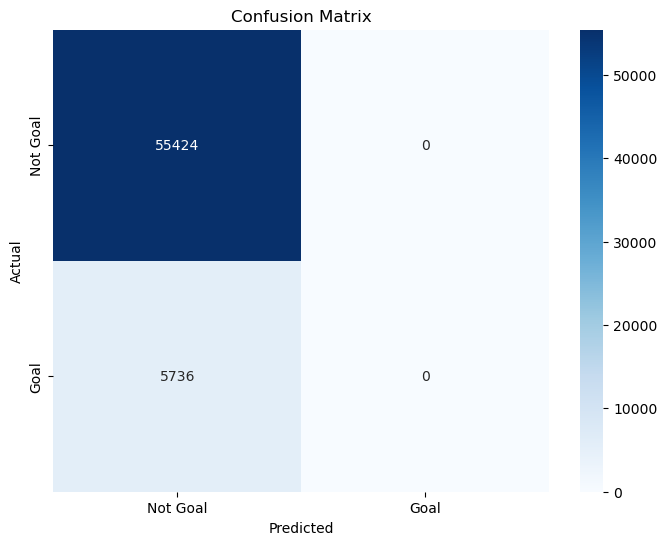

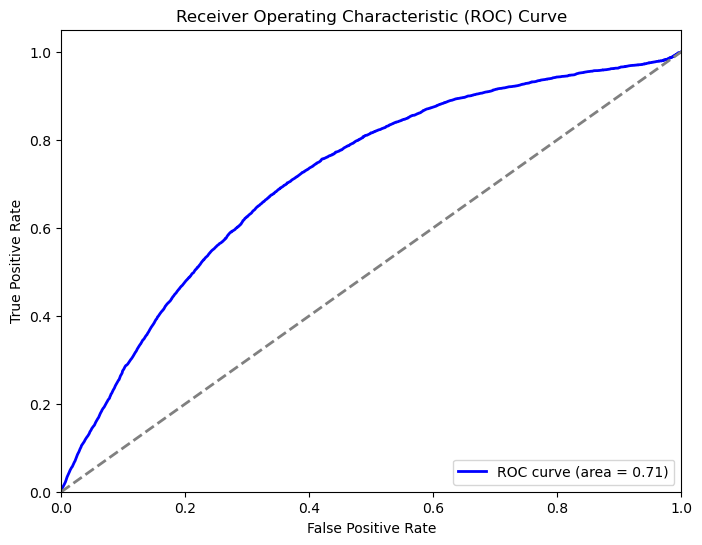

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].mean()


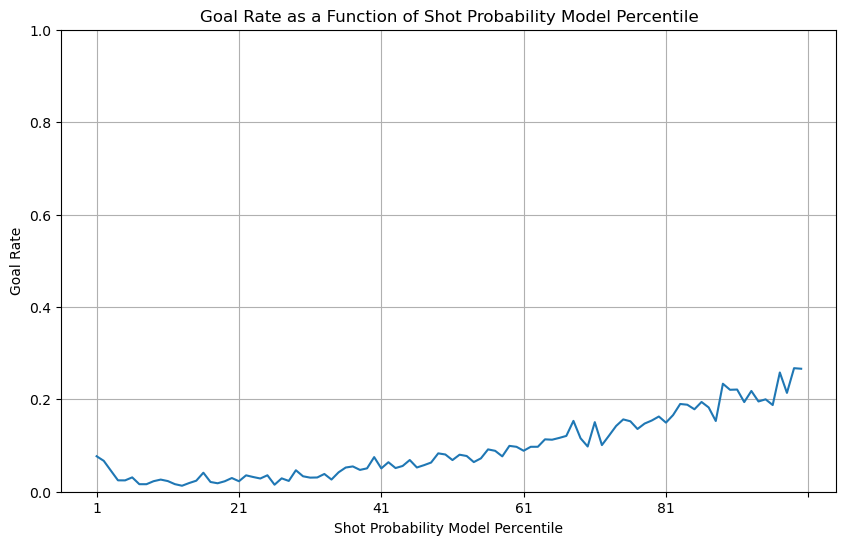

c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


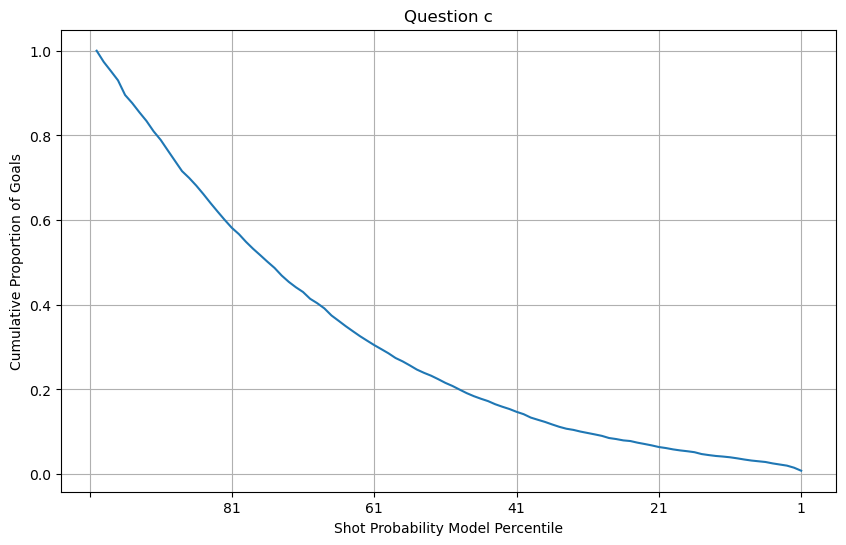

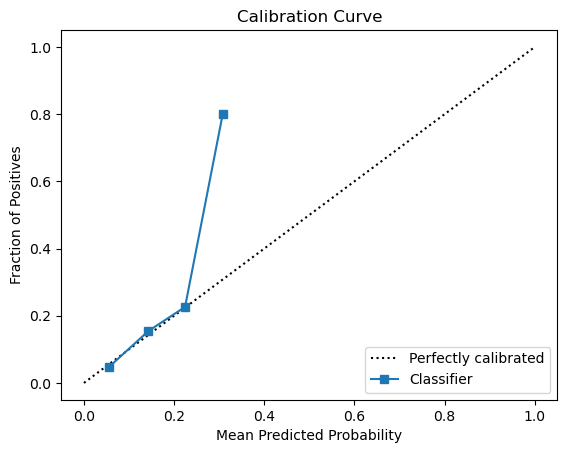

c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9062132112491825
Precision: 0.0
Confusion Matrix:
[[55424     0]
 [ 5736     0]]


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1_score,▁
precision:,▁
recall,▁
accuracy,0.90621
f1_score,0
precision:,0
recall,0


In [7]:



# Initialize a wandb run
with wandb.init(name="reproduce results", project="IFT6758-2024-B05", job_type="reproduce-results") as run:

    # Download the model artifact
    model_name = "logistic_regression_distance_angle"
    features = ['distance', 'angle']
    model_artifact = run.use_artifact(f'{model_name}:v0', type='model')
    model_dir = model_artifact.download()

    # Download the data artifact
    artifact_name = "train_val_feature_eng_1"
    get_wandb_data.download_artifact(artifact_name=artifact_name, artifact_version="v5")
    df = get_wandb_data.load_all_files_from_artifact(artifact_name=artifact_name)

    # Load the model
    model_path = f"{model_dir}\\{model_name}.pkl"
    model = joblib.load(model_path)

    # Assuming the DataFrame has columns 'features' and 'target'
    X_distance_angle = df[features].to_numpy()
    y = df['is_goal'].to_numpy()
    X_train_distance_angle, X_val_distance_angle, y_train, y_val = train_test_split(X_distance_angle, y, test_size=0.2, random_state=42)

    # Make predictions using the loaded model
    y_pred_discrete = model.predict(X_val_distance_angle)
    y_pred_proba = model.predict_proba(X_val_distance_angle)
    baseline_models_figures.plot_figures(y_pred_proba, y_pred_discrete, y_val)

    # Calculate performance metrics
    accuracy = accuracy_score(y_val, y_pred_discrete)
    precision = precision_score(y_val, y_pred_discrete)
    cm = confusion_matrix(y_val, y_pred_discrete)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Confusion Matrix:\n{cm}')

    run.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=y_val.flatten().tolist(),
                                                            preds=y_pred_discrete.flatten().tolist(),
                                                            class_names=["Not Goal", "Goal"])})


    run.config.update({
        "model_type": "LogisticRegression",
        "test_size": 0.2,
        "random_state": 42,
        "features": features,
        "model_name": model_name
    })
    run.log({"accuracy": accuracy_score(y_val, y_pred_discrete)})
    run.log({"precision:": precision_score(y_val, y_pred_discrete)})
    run.log({"recall": recall_score(y_val, y_pred_discrete)})
    run.log({"f1_score": f1_score(y_val, y_pred_discrete)})

